In [1]:
## 计算香农熵
def calEnt(dataSet):
    n = dataSet.shape[0]  # 数据集行数
    iset = dataSet.iloc[:, -1].value_counts()  # 标签数
    p = iset / n  # 每一类标签占比
    ent = (-p * np.log2(p)).sum()  # 计算香农熵
    return ent

In [2]:
import numpy as np
import pandas as pd

def creatDataSet():
    row_data = {'no surfacing':[1,1,1,0,0],
                'flippers':[1,1,0,1,1],
                'fish':['yes','yes','no','no','no']}
    dataSet = pd.DataFrame(row_data)
    return dataSet

dataSet = creatDataSet()
dataSet

,no surfacing,flippers,fish
0,1,1,yes
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [3]:
# 划分数据集的最大准则是选择最大信息增益， 也就是信息下降最快的方向
# 选择最优的列进行切分
def bestSplit(dataSet):
    baseEnt = calEnt(dataSet)    # 计算原始熵
    bestGain = 0    # 初始化信息增益
    axis = -1   # 初始化最佳切分列，标签列
    for i in range(dataSet.shape[1] - 1):   # 循环每列特征
        levels = dataSet.iloc[:, i].value_counts().index   # 提取当前列的所有值
        ents = 0   # 初始化子节点的信息熵
        for j in levels:   # 循环当前列的每个值
            childSet = dataSet[dataSet.iloc[:, i] == j]  # 某一子节点的dataframe
            ent = calEnt(childSet)   # 计算某一个子节点的信息熵
            ents += (childSet.shape[0] / dataSet.shape[0]) * ent   # 计算当前列的信息熵
        infoGain = baseEnt - ents   #  计算当前列的信息增益
        if infoGain > bestGain:
            bestGain = infoGain    # 选择最大信息增益
            axis = i
            
    return axis

bestSplit(dataSet)

0

In [4]:
# 按照给定列切分数据集
def split_data(dataSet, axis, value):
    col = dataSet.columns[axis]
    redataSet = dataSet.loc[dataSet[col] == value, :].drop(col, axis = 1)
    return redataSet

In [20]:
# 构建决策树，ID3算法
def creatTree(dataSet):
    featlist = list(dataSet.columns)   # 提取出数据集所有的列
    classlist = dataSet.iloc[:, -1].value_counts()  # 获取最后一列类标签
    # 判断最多标签数目是否等于数据集行数， 或者数据集是否只有一列
    if classlist[0] == dataSet.shape[0] or dataSet.shape[1] == 1:
        return classlist.index[0]  # 如果是，返回类标签
    axis = bestSplit(dataSet)   # 确定出当前最佳切分列的索引
    bestfeat = featlist[axis]   # 获取该索引对应的特征
    decision_tree = {bestfeat:{}}
    del featlist[axis]   # 删除当前特征
    valuelist = set(dataSet.iloc[:, axis])  # 提取最佳切分列的所有属性值
    for value in valuelist:   # 对每一个属性值递归建树
        decision_tree[bestfeat][value] = creatTree(split_data(dataSet, axis, value))
    return decision_tree

decisionTree = creatTree(dataSet)
decisionTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [14]:
# 使用决策树分类
def classify(inputTree,labels, testVec):
    firstStr = next(iter(inputTree)) #获取决策树第一个节点
    secondDict = inputTree[firstStr] #下一个字典
    featIndex = labels.index(firstStr) #第一个节点所在列的索引
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]) == dict :
                classLabel = classify(secondDict[key], labels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

def acc_classify(train,test):
    inputTree = creatTree(train) #根据测试集生成一棵树
    labels = list(train.columns) #数据集所有的列名称
    result = []
    for i in range(test.shape[0]): #对测试集中每一条数据进行循环
        testVec = test.iloc[i,:-1] #测试集中的一个实例
        classLabel = classify(inputTree,labels,testVec) #预测该实例的分类
        result.append(classLabel) #将分类结果追加到result列表中
    test['predict']=result #将预测结果追加到测试集最后一列
    acc = (test.iloc[:,-1]==test.iloc[:,-2]).mean() #计算准确率
    print(f'模型预测准确率为{acc}')
    return test

In [15]:
train = dataSet
test = dataSet.iloc[:3, :]
acc_classify(train, test)

模型预测准确率为1.0


/home/apt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,no surfacing,flippers,fish,predict
0,1,1,yes,yes
1,1,1,yes,yes
2,1,0,no,no


In [16]:
## sklearn中的决策树
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

## 导入数据集
wine = load_wine()
## 分训练集和测试集
Xtrain, Xtest, Ytrain, Ytest = train_test_split(wine.data, wine.target, test_size=0.3)
# 建立模型
# criterion参数决定不纯度的计算方法，包括信息熵(Entropy)和基尼指数(Gini Impurity)，默认基尼指数
clf = tree.DecisionTreeClassifier(criterion='entropy') 
clf = clf.fit(Xtrain, Ytrain)
score = clf.score(Xtest, Ytest)   # 返回预测的准确度


In [17]:
score_train = clf.score(Xtrain, Ytrain)
score_train

1.0

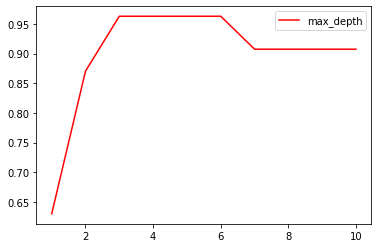

In [19]:
import matplotlib.pyplot as plt
test = []
for i in range(10):
    clf = tree.DecisionTreeClassifier(max_depth=i+1, criterion='entropy', random_state=30, splitter='random')
    clf = clf.fit(Xtrain, Ytrain)
    score = clf.score(Xtest, Ytest)
    test.append(score)
plt.plot(range(1, 11), test, color='red', label='max_depth')
plt.legend()
plt.show()